In [ ]:
# !git clone https://github.com/soCzech/TransNet

In [ ]:
# !pip3 install --upgrade --force-reinstall tensorflow-gpu==1.15.0 

In [ ]:
# !pip install protobuf==3.20.*

In [3]:
# !pip install tensorflow
# pip install pillow
# !pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# %cd TransNet

/content/TransNet


In [4]:
# !gdown --id 1bcAds2qz0rLDvwSCXFmaNozHWVu1DKj6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bcAds2qz0rLDvwSCXFmaNozHWVu1DKj6
To: /content/TransNet/viet-nam-rut-ngan-thoi-gian-xet-nghiem-virus-corona-moi-vtv24.mp4
100% 15.7M/15.7M [00:00<00:00, 125MB/s] 


In [17]:
import ffmpeg
import numpy as np
import tensorflow as tf

from transnet import TransNetParams, TransNet
from transnet_utils import draw_video_with_predictions, scenes_from_predictions

In [2]:
# initialize the network
params = TransNetParams()
params.CHECKPOINT_PATH = "./model/transnet_model-F16_L3_S2_D256"

net = TransNet(params)


[TransNet] Creating ops.


           Input (?, ?, 27, 48, 3)
           SDDCNN_1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
           > DDCNN_1 (?, ?, 27, 48, 64)
           > DDCNN_2 (?, ?, 27, 48, 64)
           MaxPool (?, ?, 13, 24, 64)
           SDDCNN_2
           > DDCNN_1 (?, ?, 13, 24, 128)
           > DDCNN_2 (?, ?, 13, 24, 128)
           MaxPool (?, ?, 6, 12, 128)
           SDDCNN_3
           > DDCNN_1 (?, ?, 6, 12, 256)
           > DDCNN_2 (?, ?, 6, 12, 256)
           MaxPool (?, ?, 3, 6, 256)
           Flatten (?, ?, 4608)
           Dense (?, ?, 256)
           Logits (?, ?, 2)
           Predictions (?, ?)
[TransNet] Network built.

[TransNet] Found 4614850 trainable parameters.

INFO:tensorflow:Restoring parameters from ./model/transnet_model-F16_L3_S2_D256
[TransNet] Parameters restored from 'transnet_model-F16_L3_S2_D256'.


In [51]:
# export video into numpy array using ffmpeg
video_stream, err = (
    ffmpeg
    .input('3.mkv')
    .output('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(params.INPUT_WIDTH, params.INPUT_HEIGHT))
    .run(capture_stdout=True)
)
video_input = np.frombuffer(video_stream, np.uint8).reshape([-1, params.INPUT_HEIGHT, params.INPUT_WIDTH, 3])

Error: ffmpeg error (see stderr output for detail)

In [52]:
video_stream, err = (
    ffmpeg
    .input('vids/3.mkv')
    .output('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(480, 240))
    .run(capture_stdout=True)
)

In [ ]:
video = np.frombuffer(video_stream, np.uint8).reshape([-1, 240, 480, 3])

In [ ]:
video = np.frombuffer(video_stream, np.uint8).reshape([-1, 240, 480, 3])

In [34]:
# predict transitions using the neural network
predictions = net.predict_video(video_input)

[TransNet] Processing video frames 129639/129639


In [42]:
import numpy as np
from PIL import Image, ImageDraw
def draw_video_with_predictions(frames: np.ndarray, predictions: np.ndarray, threshold: float = 0.1):
    print(frames.shape)
    ih, iw, ic = frames.shape[1:]
    width = 20
    if len(frames) % width != 0:
        pad_with = width - len(frames) % width
        frames = np.concatenate([frames, np.zeros([pad_with, ih, iw, ic], np.uint8)])
        predictions = np.concatenate([predictions, np.zeros([pad_with], np.float32)])
    height = len(frames) // width

    for index, frame in enumerate(frames):
        # print(index)
        # scene = frame.reshape([height, width, ih, iw, ic])
        # scene = np.concatenate(np.split(
        #     np.concatenate(np.split(scene, height), axis=2)[0], width
        # ), axis=2)[0]
        img = Image.fromarray(frame)
        img.save(f"frames/frame_{index}.png")

    scene = frames.reshape([height, width, ih, iw, ic])
    scene = np.concatenate(np.split(
        np.concatenate(np.split(scene, height), axis=2)[0], width
    ), axis=2)[0]

    img = Image.fromarray(scene)
    # img.save()
    draw = ImageDraw.Draw(img)

    adjusted_pred = predictions  # make it more visible
    i = 0
    for h in range(height):
        for w in range(width):
            draw.line((w * iw + iw - 3, h * ih,
                       w * iw + iw - 3, (h + 1) * ih), fill=(0, 0, 0), width=4)
            draw.line((w * iw + iw - 3, h * ih + ih / 2 * (1 - adjusted_pred[i]),
                       w * iw + iw - 3, h * ih + ih / 2 * (1 + adjusted_pred[i])),
                      fill=(0, 255, 0) if predictions[i] > threshold else (255, 0, 0), width=2)
            draw.line((w * iw, h * ih, (w + 1) * iw, h * ih), fill=(255, 255, 255))
            i += 1
    return img

In [44]:
video.shape

(129639, 120, 240, 3)

(300, 27, 48, 3)


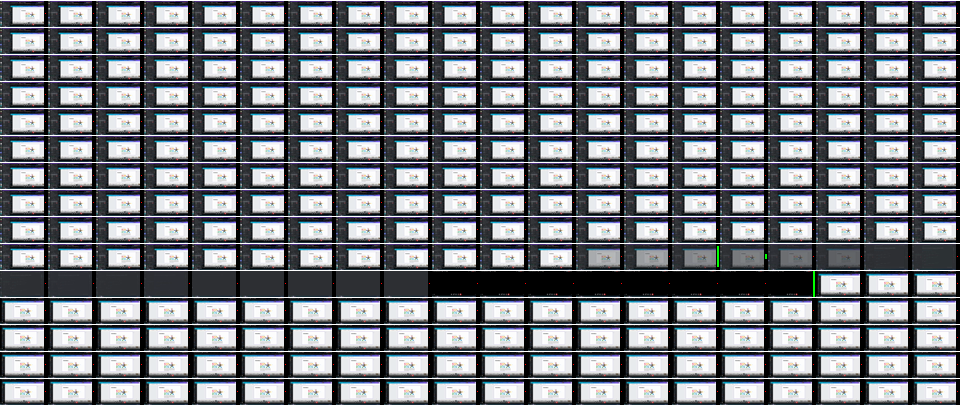

In [47]:
# For ilustration purposes, we show only 200 frames starting with frame number 8000.
draw_video_with_predictions(video_input[200:500], predictions[200:500], threshold=0.1)

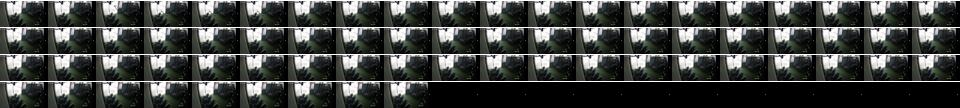

In [ ]:
draw_video_with_predictions(video[:], predictions[:], threshold=0.1)

In [ ]:
# Generate list of scenes from predictions, returns tuples of (start frame, end frame)
scenes = scenes_from_predictions(predictions, threshold=0.00001)

# For ilustration purposes, only the visualized scenes are shown.
scenes[:]

array([[ 0, 68]])

In [ ]:
predictions

array([3.34941120e-14, 5.01648080e-14, 4.18246641e-14, 4.77313840e-14,
       5.33769399e-14, 5.18896619e-14, 4.96163169e-14, 5.74814447e-14,
       6.48700589e-14, 6.33062193e-14, 5.68511099e-14, 7.32082580e-14,
       8.09334425e-14, 8.63733523e-14, 1.01236395e-13, 1.09970748e-13,
       1.24679753e-13, 1.32415197e-13, 1.60074251e-13, 1.79398488e-13,
       1.92340976e-13, 1.93180717e-13, 1.83325929e-13, 1.63700989e-13,
       1.48298271e-13, 1.40796988e-13, 1.29573747e-13, 1.14228099e-13,
       1.06309147e-13, 1.03385223e-13, 9.93552164e-14, 1.04171839e-13,
       1.09335358e-13, 1.14342753e-13, 1.19136472e-13, 1.33229677e-13,
       1.41932662e-13, 1.48806586e-13, 1.59250800e-13, 1.74238187e-13,
       1.73142953e-13, 1.55218259e-13, 1.38882476e-13, 1.10262690e-13,
       1.05761062e-13, 7.25449499e-14, 6.63256207e-14, 9.93935023e-14,
       5.53678976e-14, 2.94907633e-14, 2.00626394e-14, 2.81521463e-14,
       3.25870007e-14, 4.94426819e-14, 7.45050790e-14, 8.66208215e-14,
      

In [ ]:
# Importing Image module from PIL package  
from PIL import Image  
import PIL  
  
# creating a image object (main image)  
im1 = Image.open(r"C:\Users\toand\OneDrive\Hình ảnh\Capture.PNG")  
  
# save a image using extension 
im1 = im1.save("geeks.png") 